# Carrefour Express. Understanding sales for site selection

Carrefour Express, a chain of small-sized supermarkets, wants to reorganize (open/close) their stores in the city of Madrid. In order to define an optimal plan of openings and closures, they first need to understand why some stores are performing better (in terms of annual sales) than others, and identify areas where they could have a high performance.

They have provided us with the stores they have in the city of Madrid, together with the average annual sales of the last three years**.

In this notebook, an analysis is run to understand the main sales drivers and build a predictive model to identify areas with a high sales potential. The main steps followed are:
1. Processing data. Geocoding
2. Analysis of CE data (standard and spatial analysis)
3. Enrichment

 3.1 Isochrones

 3.2 Data discovery and enrichment
 
4. Modeling
5. Grid and model projection


In order to run this analysis, we're going to use the Python library **CARTOframes** (https://carto.com/developers/cartoframes/) that provides functionality to visualize spatial data, as well as essential functionality in spatial analysis such as geocoding, isochrones, and data enrichment.



** _Note the annual sales are not CE actual data._

## 0. Setup

In [86]:
import geopandas as gpd
import ipywidgets as widgets
import json
import matplotlib
import matplotlib.pyplot as plt
import mercantile
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import pyproj
import seaborn as sns

from cartoframes.auth import set_default_credentials
from cartoframes.data.observatory import *
from cartoframes.data.services import Geocoding, Isolines
from cartoframes.viz import *
from IPython.display import clear_output, display
from shapely import wkt
from shapely.geometry import box, Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import *
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')

%matplotlib inline

In [87]:
##NOUSAR
cc_file = '/Users/malvarez/carto_credentials.json'

with open(cc_file, 'r') as f:
    cred = json.load(f)
    set_default_credentials(
        base_url=cred['base_url'],
        api_key=cred['api_key'])
f.close()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/malvarez/carto_credentials.json'

## 1. Load data

In [3]:
stores = pd.read_csv('data/ce_stores.csv')
stores.head()

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139
2,CARREFOUR EXPRESS RAMIREZ DEL PRADO,CALLE DE JUAN DE MARIANA 8,28045,MADRID,COMUNIDAD DE MADRID,14.049265
3,CARREFOUR EXPRESS PASTORA IMPERIO. 1,CALLE PASTORA IMPERIO 1,28036,MADRID,COMUNIDAD DE MADRID,15.864545
4,CARREFOUR EXPRESS BÉJAR,CALLE DE BÉJAR 1,28028,MADRID,COMUNIDAD DE MADRID,22.766015


In [4]:
stores.shape

(57, 6)

## 2. Processing data. Geocoding

In [ ]:
## DE PAGO 
gc = Geocoding()

In [ ]:
## DE PAGO 
# WORKSHOP: Geocode stores

In [ ]:
## DE PAGO 
gdf.head(2)

In [ ]:
## DE PAGO 
stores = gdf[stores.columns.tolist() + ['the_geom']].rename(columns={'the_geom':'geometry'})
stores.head(2)

In [8]:
# WORKSHOP
stores = pd.read_csv('data/ce_stores_geocoded.csv')

#WTK es una aplicación de shapely. GEOPANDAS = PANDAS + SHAPELY
stores['geometry'] = stores['geometry'].apply(wkt.loads)

##crs --> sobre qué proyección le metes la long,lat
stores = gpd.GeoDataFrame(stores, crs='epsg:4326')
stores.head(8)

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales,geometry
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558,POINT (-3.70606 40.42811)
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139,POINT (-3.78267 40.45914)
2,CARREFOUR EXPRESS RAMIREZ DEL PRADO,CALLE DE JUAN DE MARIANA 8,28045,MADRID,COMUNIDAD DE MADRID,14.049265,POINT (-3.68655 40.39912)
3,CARREFOUR EXPRESS PASTORA IMPERIO. 1,CALLE PASTORA IMPERIO 1,28036,MADRID,COMUNIDAD DE MADRID,15.864545,POINT (-3.67465 40.48095)
4,CARREFOUR EXPRESS BÉJAR,CALLE DE BÉJAR 1,28028,MADRID,COMUNIDAD DE MADRID,22.766015,POINT (-3.67453 40.43522)
5,CARREFOUR EXPRESS SANTA ISABEL 28,CALLE DE SANTA ISABEL 28,28012,MADRID,COMUNIDAD DE MADRID,19.157180,POINT (-3.69838 40.41083)
6,CARREFOUR EXPRESS GENERAL MARTÍNEZ CAMPOS,PASEO DEL GENERAL MARTÍNEZ CAMPOS 24,28010,MADRID,COMUNIDAD DE MADRID,29.078950,POINT (-3.69447 40.43493)
7,CARREFOUR EXPRESS CEPSA GLORIETA DEL YUCATÁN,GLORIETA YUCATÁN,28043,MADRID,COMUNIDAD DE MADRID,12.162754,POINT (-3.62726 40.45077)


In [13]:
# WORKSHOP: Visualize stores with their names
Map(Layer(stores, 
          popup_hover=popup_element('name',title='Tienda')))

## 2. Data Analysis

In [14]:
stores['name'] = stores['name'].str[18:]

Text(0.5, 1.0, 'Total sales')

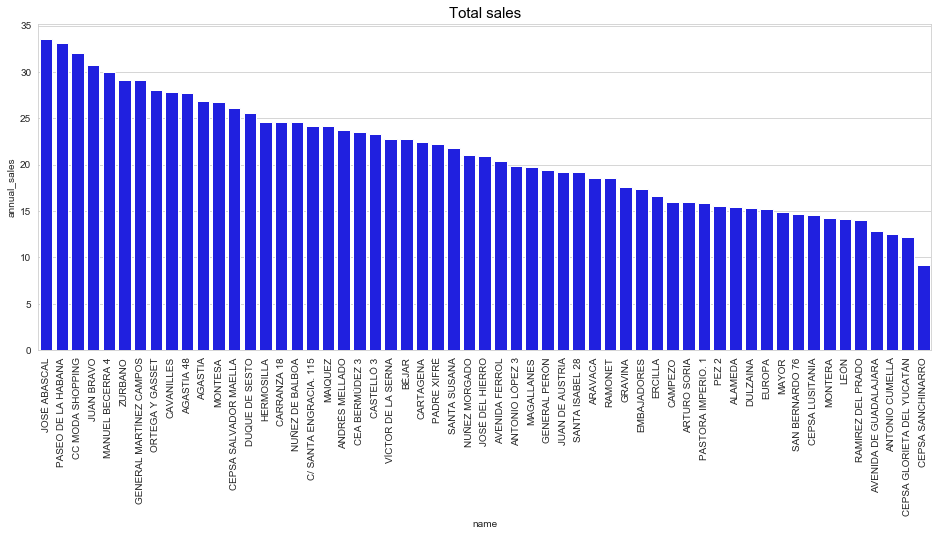

In [15]:
plt.figure(figsize=(16,6))
sns.barplot(x='name', y='annual_sales', data=stores.sort_values('annual_sales', ascending=False),color='blue', saturation=0.75)
plt.xticks(rotation='vertical')
plt.title('Total sales', fontsize=15, color='black', weight='medium')

In [21]:
#WORKSHOP: Visualize stores with point size proportional to sales and popup info: name and annual sales
Map(Layer(stores,
          style=size_continuous_style('annual_sales'),
          popup_hover=popup_element('name',title='Tienda')))

## 3. Enrichment

Sales in a grocery store are mainly influenced by:
 - The characteristics of the population who live in the area around the store
 - Competitors
 - How busy the area around is (residential, touristic, work)
 - How many people move around the area
 
In order to enrich our initial dataset with this information, we first need to define the area of influence (catchment areas) of the different stores. Once we have the catchment area, we'll bring all the information related to that area.

### 3.1 Isochrones

Because of the characteristics of Carrefour Express' customers, we can define their catchment areas by acknowledging that:
- Their customers usually make small to medium purchases
- Their customers live close to the supermarket

In [ ]:
# DE PAGO
iso_service = Isolines()

In [24]:
##DE PAGO
# WORKSHOP: Calculate 5, 7.5, and 10 minute walking isochrones (exclusive**),
## Dataframe, tiempo en segundos, modelo andando
isochrones_gdf, _ = iso_service.ischrones(stores,[300,450,600],model="walk")

NameError: name 'iso_service' is not defined

In [25]:
isochrones_gdf

NameError: name 'isochrones_gdf' is not defined

In [26]:
Map(Layer(isochrones_gdf, geom_col='the_geom', style=basic_style(opacity=0.3)))

NameError: name 'isochrones_gdf' is not defined

In [27]:
stores['iso_5walk'] = isochrones_gdf.loc[isochrones_gdf['data_range'] == 300, 'the_geom'].values
stores['iso_10walk'] = isochrones_gdf.loc[isochrones_gdf['data_range'] == 600, 'the_geom'].values

NameError: name 'isochrones_gdf' is not defined

In [28]:
## WORKSHOP
stores = pd.read_csv('data/ce_stores_isochrones.csv')
stores['geometry'] = stores['geometry'].apply(wkt.loads)
stores['iso_5walk'] = stores['iso_5walk'].apply(wkt.loads)
stores['iso_10walk'] = stores['iso_10walk'].apply(wkt.loads)
stores = gpd.GeoDataFrame(stores, crs='epsg:4326')
stores.head(2)

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales,geometry,iso_5walk,iso_10walk
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558,POINT (-3.70606 40.42811),"(POLYGON ((-3.7091732 40.4283142, -3.708744 40...","(POLYGON ((-3.7114048 40.4271126, -3.7111473 4..."
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139,POINT (-3.78267 40.45914),"(POLYGON ((-3.7853909 40.4598999, -3.7849617 4...","(POLYGON ((-3.7888241 40.4598999, -3.7883949 4..."


In [31]:
Map(Layer(stores,
          geom_col='iso_5walk',
          style = basic_style(opacity=0.2)))

### 3.2 Enrichment

#### 3.2.1 POIs

In [32]:
## DE PAGO
enrichment = Enrichment()

AttributeError: 'NoneType' object has no attribute 'get_do_credentials'

In [33]:
Catalog().country('esp').categories

[<Category.get('demographics')>,
 <Category.get('environmental')>,
 <Category.get('financial')>,
 <Category.get('housing')>,
 <Category.get('human_mobility')>,
 <Category.get('points_of_interest')>,
 <Category.get('road_traffic')>]

In [34]:
Catalog().country('esp').category('points_of_interest').datasets

[<Dataset.get('pb_pointsofint_94bda91b')>,
 <Dataset.get('here_points_of_i_51e17e67')>]

In [35]:
dataset = Dataset.get('pb_pointsofint_94bda91b')

In [36]:
dataset.head()

,HTTP,ISO3,NAME,SIC1,SIC2,SIC8,CLASS,EMAIL,GROUP,PB_ID,STABB,geoid,FAXNUM,MICODE,TEL_NUM,do_date,LATITUDE,OPEN_24H,POSTCODE,do_label,AREANAME1,AREANAME2,AREANAME3,AREANAME4,BRANDNAME,GEORESULT,LONGITUDE,SUB_CLASS,AGENT_CODE,TRADE_NAME,YEAR_START,STATUS_CODE,BUSINESS_LINE,CURRENCY_CODE,EMPLOYEE_HERE,EXCHANGE_NAME,TICKER_SYMBOL,EMPLOYEE_COUNT,FAMILY_MEMBERS,FRANCHISE_NAME,HIERARCHY_CODE,PARENT_ADDRESS,PARENT_COUNTRY,TRADE_DIVISION,ADDRESSLASTLINE,CONFIDENCE_CODE,MAINADDRESSLINE,PARENT_POSTCODE,FORMATTEDADDRESS,PARENT_AREANAME1,PARENT_AREANAME3,SIC8_DESCRIPTION,ALT_INDUSTRY_CODE,LEGAL_STATUS_CODE,SALES_VOLUME_LOCAL,COUNTRY_ACCESS_CODE,PARENT_BUSINESS_NAME,SUBSIDIARY_INDICATOR,PARENT_STREET_ADDRESS,GLOBAL_ULTIMATE_ADDRESS,GLOBAL_ULTIMATE_COUNTRY,SALES_VOLUME_US_DOLLARS,GLOBAL_ULTIMATE_POSTCODE,DOMESTIC_ULTIMATE_ADDRESS,GLOBAL_ULTIMATE_AREANAME1,GLOBAL_ULTIMATE_AREANAME3,GLOBAL_ULTIMATE_INDICATOR,DOMESTIC_ULTIMATE_POSTCODE,DOMESTIC_ULTIMATE_AREANAME1,DOMESTIC_ULTIMATE_AREANAME3,GLOBAL_ULTIMATE_BUSINESS_NAME,GLOBAL_ULTIMATE_STREET_ADDRESS,DOMESTIC_ULTIMATE_BUSINESS_NAME,DOMESTIC_ULTIMATE_STREET_ADDRESS
0,None,ESP,PANLUPA SOCIEDAD LIMITADA.,5311,None,53110000,DEPARTMENT STORES,None,GENERAL MERCHANDISE STORES,1174003222,AN,1174003222,None,10010101,914 90 89 00,2019-12-01,42.57577588304664,None,03540,FUERTE JANDIA SL,CANTABRIA (SANTANDER),CASTRO-URDIALES,RIBEIRA,CORRUBEDO(SANTA MARÍA),None,S8HPNTSCZA,-15.41524,DEPARTMENT STORES,G,None,2014,0,DEPARTMENT STORES,5080,0000010,None,None,0000006,00000,None,04,None,None,DIVISION G. - RETAIL TRADE,"39700, CASTRO-URDIALES, CASTRO-URDIALES",HIGH,"CALLE PORTO (AGUIÑO), S/N",None,"AVENIDA RAFAEL CABRERA, 24 - 1 9, 35002, LAS P...",None,None,DEPARTMENT STORES,350,003,000000000001316842,0034,None,0,None,"AVENIDA AHONES 6, 28043, MADRID, MADRID, SPAIN",None,000000002399041,None,None,None,None,N,28043,MADRID,MADRID,None,AVENIDA AHONES 6,ABBA BIPLAZA SL,None
1,None,AND,SUPERBARATO TENERIFE 2014 SL.,5311,None,53110000,DEPARTMENT STORES,None,GENERAL MERCHANDISE STORES,1173016411,CN,1173016411,None,10010101,None,2019-12-01,42.34191,None,AD200,SUPER-TURRE SL,MADRID,ALCALÁ DE HENARES,BURGOS,BURGOS,None,S5HP--SCZA,-1.89425,DEPARTMENT STORES,G,CAPRABO CANILLO,2009,0,DEPARTMENT STORES,5080,0000008,None,None,0000009,00000,None,00,None,None,DIVISION G. - RETAIL TRADE,"28806, ALCALA DE HENARES, ALCALÁ DE HENARES",LOW,"CALLE VITORIA, 27 - BJ",None,"AVENIDA DE ALMERIA 43, 04639, TURRE, TURRE",None,None,DEPARTMENT STORES,350,003,000000000000862840,00376,LA DESPENSA DE TOLEDO SL,0,None,None,None,000000001119770,None,None,None,None,N,None,None,None,None,None,None,None
2,None,AND,GALERIAS PISCIS SL,5311,None,53110000,DEPARTMENT STORES,None,GENERAL MERCHANDISE STORES,1171317268,CT,1171317268,937 67 90 80,10010101,937 67 82 26,2019-12-01,43.21104,None,AD100,GRAN BLAU SL,LERIDA,LÉRIDA,ZALLA,None,None,S8-PN-SCZA,1.5415050513443043,DEPARTMENT STORES,B,None,1995,0,DEPARTMENT STORES,5080,0000008,None,None,0000010,00000,None,00,None,None,DIVISION G. - RETAIL TRADE,"25001, LLEIDA, LÉRIDA",MEDIUM,AVENIDA LANZAGORTA 27,None,PJ ANTONIA FONT CAMINAL (PRAT DE LES OQUES) LO...,None,None,DEPARTMENT STORES,350,003,000000000000326041,00376,None,0,None,None,None,000000001560950,None,None,None,None,N,None,None,None,None,None,None,None
3,None,AND,THE NAVY EXCHANGE SUCURSAL EN ESPANA,5311,5411,53110000,DEPARTMENT STORES,None,GENERAL MERCHANDISE STORES,1263455053,AN,1263455053,None,10010101,956 82 23 91,2019-12-01,42.50560382590716,None,AD400,2012 LIZANDA TORTAJADA SOCIEDAD LIMITADA.,None,ANDORRA,ANDORRA LA VELLA,None,None,S5-PNTSCZA,-0.4021595325387393,DEPARTMENT STORES,G,None,1970,0,DEPARTMENT STORES,5080,0000007,None,None,0000018,00000,None,00,None,None,DIVISION G. - RETAIL TRADE,"AD200, EL PAS DE LA CASA",MEDIUM,92 C PRAT DE LA CREU,None,"CALLE MARINA ALTA 5, 46015, VALENCIA, VALENCIA",None,None,DEPARTMENT STORES,350,000,000000000001500000,00376,EL HAYEDO GESTION DE ACTIVOS SL.,0,None,None,None,000000000870538,None,None,None,None,N,None,

In [40]:
# Para ver si aplica a todo la región que buscas
dataset.geom_coverage()

In [38]:
dataset.to_dict()

{'id': 'carto-do.pitney_bowes.pointsofinterest_pointsofinterest_esp_latlon_v1_monthly_v1',
 'slug': 'pb_pointsofint_94bda91b',
 'name': 'Points of Interest',
 'description': 'Point of interest database per categories',
 'country_id': 'esp',
 'geography_id': 'carto-do.pitney_bowes.geography_esp_latlon_v1',
 'geography_name': 'Points of Interest',
 'geography_description': 'Location of Points of Interest',
 'category_id': 'points_of_interest',
 'category_name': 'Points of Interest',
 'provider_id': 'pitney_bowes',
 'provider_name': 'Pitney Bowes',
 'data_source_id': 'pointsofinterest',
 'lang': 'eng',
 'temporal_aggregation': 'monthly',
 'time_coverage': None,
 'update_frequency': None,
 'version': 'v1',
 'is_public_data': False}

In [41]:
dataset.variables #.to_dataframe()

[<Variable.get('SALES_VOLUME_US_b05ebdf')> #'Total annual sales/revenue for this business, expr...',
 <Variable.get('SALES_VOLUME_LO_4ddfdb3b')> #'Estimated Total annual sales/revenue for this busi...',
 <Variable.get('EMPLOYEE_COUNT_17bf2a35')> #'Estimated Total number of employees in the busines...',
 <Variable.get('EMPLOYEE_HERE_5fb4b74')> #'Estimated Number of employees at current location',
 <Variable.get('YEAR_START_a6b8e14f')> #'Year when current ownership or management assumed ...',
 <Variable.get('SIC2_f25bef7c')> #'US 1987 Standard Industrial Classification code fo...',
 <Variable.get('SIC1_6b52bec6')> #'US 1987 Standard Industrial Classification (SIC) c...',
 <Variable.get('BUSINESS_LINE_80b63050')> #'Description of the operations or activities of the...',
 <Variable.get('OPEN_24H_ec6a47ff')> #'Indicator of Twenty Four Hour Opening',
 <Variable.get('HTTP_c7828b23')> #'URL (Uniform Resource Locator) address of the busi...',
 <Variable.get('EMAIL_5ba405e8')> #'Email address of

In [42]:
dataset.variables.to_dataframe()

,id,slug,name,description,column_name,db_type,dataset_id,agg_method,variable_group_id,starred
0,carto-do.pitney_bowes.pointsofinterest_pointso...,SALES_VOLUME_US_b05ebdf,Sales Volume Us Dollars,"Total annual sales/revenue for this business, ...",SALES_VOLUME_US_DOLLARS,INTEGER,carto-do.pitney_bowes.pointsofinterest_pointso...,SUM,None,None
1,carto-do.pitney_bowes.pointsofinterest_pointso...,SALES_VOLUME_LO_4ddfdb3b,Sales Volume Local,Estimated Total annual sales/revenue for this ...,SALES_VOLUME_LOCAL,INTEGER,carto-do.pitney_bowes.pointsofinterest_pointso...,SUM,None,None
2,carto-do.pitney_bowes.pointsofinterest_pointso...,EMPLOYEE_COUNT_17bf2a35,Employee Count,Estimated Total number of employees in the bus...,EMPLOYEE_COUNT,INTEGER,carto-do.pitney_bowes.pointsofinterest_pointso...,SUM,None,None
3,carto-do.pitney_bowes.pointsofinterest_pointso...,EMPLOYEE_HERE_5fb4b74,Employee Here,Estimated Number of employees at current location,EMPLOYEE_HERE,INTEGER,carto-do.pitney_bowes.pointsofinterest_pointso...,SUM,None,None
4,carto-do.pitney_bowes.pointsofinterest_pointso...,YEAR_START_a6b8e14f,Year Start,Year when current ownership or management assu...,YEAR_START,INTEGER,carto-do.pitney_bowes.pointsofinterest_pointso...,AVG,None,None
...,...,...,...,...,...,...,...,...,...,...
67,carto-do.pitney_bowes.pointsofinterest_pointso...,TICKER_SYMBOL_5fa0c586,Ticker Symbol,Ticker symbol,TICKER_SYMBOL,STRING,carto-do.pitney_bowes.pointsofinterest_pointso...,None,None,None
68,carto-do.pitney_bowes.pointsofinterest_pointso...,HIERARCHY_CODE_8b924b08,Hierarchy Code,Number used with the status and subsidiary ind...,HIERARCHY_CODE,STRING,carto-do.pitney_bowes.pointsofinterest_pointso...,None,None,None
69,carto-do.pitney_bowes.pointsofinterest_pointso...,FAMILY_MEMBERS_ac05020d,Family Members,Number of family members including the global ...,FAMILY_MEMBERS,STRING,carto-do.pitney_bowes.pointsofinterest_pointso...,None,None,None
70,carto-do.pitney_bowes.pointsofinterest_pointso...,GLOBAL_ULTIMATE_4d03d415,Global Ultimate Postcode,Postal code of the ultimate company,GLOBAL_ULTIMATE_POSTCODE,STRING,carto-do.pitney_bowes.pointsofinterest_pointso...,None,None,None


In [43]:
Variable.get('CLASS_517d6003').to_dict()

{'id': 'carto-do.pitney_bowes.pointsofinterest_pointsofinterest_esp_latlon_v1_monthly_v1.CLASS',
 'slug': 'CLASS_517d6003',
 'name': 'Class',
 'description': 'Level 3 POI category',
 'column_name': 'CLASS',
 'db_type': 'STRING',
 'dataset_id': 'carto-do.pitney_bowes.pointsofinterest_pointsofinterest_esp_latlon_v1_monthly_v1',
 'agg_method': None,
 'variable_group_id': None,
 'starred': None}

In [44]:
#DE PAGO
Catalog().subscriptions()

ValueError: Credentials attribute is required. Please pass a `Credentials` instance or use the `set_default_credentials` function.

##### Number of POIs

This gives us an idea of how busy the area is.

In [48]:
#WORKSHOP: Enrich with all POIs within the 5 minute isochrone
enriched_dataset_gdf = enrichment.enrich_polygons(
    stores,
    variables=['CLASS_517d6003'],
    aggregation = 'COUNT',
    geom_col='iso_5walk')

NameError: name 'enrichment' is not defined

In [49]:
enriched_dataset_gdf.head()

NameError: name 'enriched_dataset_gdf' is not defined

In [50]:
Map(Layer(enriched_dataset_gdf, geom_col='iso_5walk', style=color_bins_style('CLASS')))

NameError: name 'enriched_dataset_gdf' is not defined

In [51]:
stores['n_pois'] = enriched_dataset_gdf['CLASS'].values

NameError: name 'enriched_dataset_gdf' is not defined

##### Number of competitors

We count the number of competitors within the 10 minute isochrone. This represents all the supermarkets that customers within our stores can find within a 5-minute-walk distance.

In [52]:
# Watch out! 10 minutes
enriched_dataset_gdf = enrichment.enrich_polygons(
    stores,
    variables=['CLASS_517d6003'],
    aggregation='COUNT',
    geom_col='iso_10walk',
    ## METER EL COMPETIDOR.
    filters={'carto-do.pitney_bowes.pointsofinterest_pointsofinterest_esp_latlon_v1_monthly_v1.CLASS': 
             "= 'GROCERY STORES'"}
)

NameError: name 'enrichment' is not defined

In [53]:
stores['n_competitors'] = enriched_dataset_gdf['CLASS'].values
stores.head(3)

NameError: name 'enriched_dataset_gdf' is not defined

##### Enrichment visualization

In [54]:
competitors = pd.read_csv('data/competitors.csv')
competitors.columns = map(str.lower, competitors.columns)
competitors = competitors[~competitors['name'].str.contains('CARREFOUR EXPRESS')]
competitors['geom'] = competitors['geom'].apply(wkt.loads)
competitors = gpd.GeoDataFrame(competitors, geometry='geom', crs='epsg:4326')
competitors.head()

FileNotFoundError: [Errno 2] File data/competitors.csv does not exist: 'data/competitors.csv'

In [55]:
Map([Layer(stores, geom_col='iso_10walk', style=basic_style(opacity=0.3)),
     Layer(competitors, style=basic_style(size=3, stroke_width=0.5))])

NameError: name 'competitors' is not defined

## Sociodemographic and socioeconomic data

In [56]:
dataset = Dataset.get('u360_demographic_94266d3')

In [57]:
dataset.to_dict()

{'id': 'carto-do.unica360.demographics_demographics_esp_grid100x100m_2018_yearly_2018',
 'slug': 'u360_demographic_94266d3',
 'name': 'Sociodemographics',
 'description': 'Basic demographic data, purchasing power by household, annual famility expenditure by category of spent, etc.',
 'country_id': 'esp',
 'geography_id': 'carto-do.unica360.geography_esp_grid100x100m_2018',
 'geography_name': 'Spain Grid 100x100m',
 'geography_description': None,
 'category_id': 'demographics',
 'category_name': 'Demographics',
 'provider_id': 'unica360',
 'provider_name': 'Unica360',
 'data_source_id': 'demographics',
 'lang': 'spa',
 'temporal_aggregation': 'yearly',
 'time_coverage': None,
 'update_frequency': None,
 'version': '2018',
 'is_public_data': False}

In [73]:
dataset.head()

,HOG,P_T,id_x,id_y,geoid,EURO_RIC,EXTR_NAC,INM_POBR,n_fincas,UE_28_NOR,n_viv_inm,renta_ind,P_ED_00_04_H,P_ED_00_04_M,P_ED_00_14_H,P_ED_00_14_M,P_ED_15_24_H,P_ED_15_24_M,P_ED_25_44_H,P_ED_25_44_M,P_ED_45_64_H,P_ED_45_64_M,P_ED_65_79_H,P_ED_65_79_M,renthog_06_M,P_ED_80_MAS_H,P_ED_80_MAS_M,P_EST_RESTO_M,renta_hab_disp,renta_hog_neta,renta_tit_disp,renta_tit_bruta,P_EST_4_2_GRADO_M,P_EST_5_3_GRADO_M,C02_09_GASTO_M_ocio_M,C02_06_GASTO_M_salud_M,C02_12_GASTO_M_otros_M,C02_03_GASTO_M_textil_M,C02_10_GASTO_M_ense_a_M,C02_11_GASTO_M_horeca_M,C02_02_GASTO_M_bebidas_M,C02_05_GASTO_M_muebles_M,C02_04_GASTO_M_vivienda_M,C02_07_GASTO_M_transporte_M,C02_01_GASTO_M_alimentacion_M,C02_08_GASTO_M_comunicaciones_M
0,0.818620,2.552167,-9749,52436,-9749#52436,0.019262,0.105939,0.043339,5,0.025682,1,0.881064,0.048154,0.048154,0.165329,0.168539,0.112360,0.112360,0.330658,0.309791,0.378812,0.409310,0.189406,0.215088,30547.024973,0.056180,0.104334,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
1,2.455859,7.656501,-9749,52437,-9749#52437,0.057785,0.317817,0.130016,3,0.077047,3,0.881064,0.144462,0.144462,0.495987,0.505618,0.337079,0.337079,0.991974,0.929374,1.136437,1.227929,0.568218,0.645265,30547.024973,0.168539,0.313002,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
2,0.818620,2.552167,-9749,52443,-9749#52443,0.019262,0.105939,0.043339,9,0.025682,1,0.881064,0.048154,0.048154,0.165329,0.168539,0.112360,0.112360,0.330658,0.309791,0.378812,0.409310,0.189406,0.215088,30547.024973,0.056180,0.104334,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
3,1.637239,5.104334,-9749,52445,-9749#52445,0.038523,0.211878,0.086677,2,0.051364,2,0.881064,0.096308,0.096308,0.330658,0.337079,0.224719,0.224719,0.661316,0.619583,0.757624,0.818620,0.378812,0.430177,30547.024973,0.112360,0.208668,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
4,0.818620,2.552167,-9749,52480,-9749#52480,0.019262,0.105939,0.043339,2,0.025682,1,0.881064,0.048154,0.048154,0.165329,0.168539,0.112360,0.112360,0.330658,0.309791,0.378812,0.409310,0.189406,0.215088,30547.024973,0.056180,0.104334,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
5,4.093098,12.760835,-9749,52481,-9749#52481,0.096308,0.529695,0.216693,7,0.128411,5,0.881064,0.240770,0.240770,0.826645,0.842697,0.561798,0.561798,1.653291,1.548957,1.894061,2.046549,0.947030,1.075441,30547.024973,0.280899,0.521669,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
6,2.455859,7.656501,-9749,52482,-9749#52482,0.057785,0.317817,0.130016,7,0.077047,3,0.881064,0.144462,0.144462,0.495987,0.505618,0.337079,0.337079,0.991974,0.929374,1.136437,1.227929,0.568218,0.645265,30547.024973,0.168539,0.313002,0.283109,8447.643184,24528.436063,16056.513286,19500.593094,0.630558,0.086333,2407.571579,972.557279,2820.324793,2071.532869,301.628038,2573.096394,830.324018,1407.541576,7380.681384,4129.074203,5284.809882,982.470398
7,4.093098,12.760835,-9749,52483,-9749#52483,0.096308,0.529695,0.216693,7,0.128411,5,0.881064,0.240770,0.240770,0.826645,0.842697,0.561798,0.561

In [74]:
dataset.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [59]:
dataset.variables

[<Variable.get('P_ED_45_64_H_46901c45')> #'P_ED_45_64_H',
 <Variable.get('P_EST_4_2_GRADO_724ab0d4')> #'% población > 16 años con estudios nivel 4: 2º gra...',
 <Variable.get('C02_12_GASTO_M__cf519413')> #'C02_12_GASTO_M_otros_M',
 <Variable.get('renta_ind_1b9e781f')> #'Renta, índice sobre media poblacional',
 <Variable.get('C02_11_GASTO_M__972c29d2')> #'C02_11_GASTO_M_horeca_M',
 <Variable.get('C02_10_GASTO_M__34ad15ea')> #'C02_10_GASTO_M_enseña_M',
 <Variable.get('C02_09_GASTO_M__a6469b49')> #'C02_09_GASTO_M_ocio_M',
 <Variable.get('C02_08_GASTO_M__a8b8fd74')> #'C02_08_GASTO_M_comunicaciones_M',
 <Variable.get('C02_07_GASTO_M__3f74fe6')> #'C02_07_GASTO_M_transporte_M',
 <Variable.get('C02_06_GASTO_M__59734b42')> #'C02_06_GASTO_M_salud_M',
 <Variable.get('C02_05_GASTO_M__622b4e50')> #'C02_05_GASTO_M_muebles_M',
 <Variable.get('C02_04_GASTO_M__7a988da2')> #'C02_04_GASTO_M_vivienda_M',
 <Variable.get('C02_03_GASTO_M__51005740')> #'C02_03_GASTO_M_textil_M',
 <Variable.get('C02_02_GASTO_M

In [60]:
Variable.get('C02_01_GASTO_M__31a5c349').to_dict()

{'id': 'carto-do.unica360.demographics_demographics_esp_grid100x100m_2018_yearly_2018.C02_01_GASTO_M_alimentacion_M',
 'slug': 'C02_01_GASTO_M__31a5c349',
 'name': 'C02_01_GASTO_M_alimentacion_M',
 'description': 'Gasto medio por hogar en las 12 grandes categorías COICOP',
 'column_name': 'C02_01_GASTO_M_alimentacion_M',
 'db_type': 'FLOAT',
 'dataset_id': 'carto-do.unica360.demographics_demographics_esp_grid100x100m_2018_yearly_2018',
 'agg_method': 'AVG',
 'variable_group_id': None,
 'starred': False}

In [61]:
vars_enrichment = ['P_T_9f18c911',
                   'P_ED_00_14_M_faf65d3', 'P_ED_00_14_H_7fc5915c', 'P_ED_15_24_M_eba0503a', 'P_ED_15_24_H_9bcaa4b5',
                   'P_ED_25_44_M_ff23157b', 'P_ED_25_44_H_8f49e1f4', 'P_ED_45_64_M_36fae8ca', 'P_ED_45_64_H_46901c45',
                   'P_ED_65_79_M_11010dd5', 'P_ED_65_79_H_616bf95a', 'P_ED_80_MAS_M_77231c9', 'P_ED_80_MAS_H_7718c546',
                   'renta_hab_disp_250f21df', 'C02_01_GASTO_M__31a5c349']

In [62]:
enriched_dataset_gdf = enrichment.enrich_polygons(
    stores,
    variables=vars_enrichment,
    geom_col='iso_5walk'
)

NameError: name 'enrichment' is not defined

In [63]:
stores = enriched_dataset_gdf
stores.crs = 'epsg:4326'
stores.columns = map(str.lower, stores.columns)
stores.head()

NameError: name 'enriched_dataset_gdf' is not defined

#### 3.2.3 Spatial lags

##### 3.2.3.1 Distance to Puerta del Sol

In [64]:
madrid_city_center = Point(-3.703367, 40.416892)

In [65]:
proj_in = pyproj.Proj('epsg:4326')
proj_out = pyproj.Proj('epsg:25830')
project = pyproj.Transformer.from_proj(proj_in, proj_out).transform

In [66]:
stores['dist_cc'] = stores.set_geometry('geometry').to_crs('epsg:25830').distance(
    Point(project(madrid_city_center.y, madrid_city_center.x))).values

In [67]:
stores.head(2)

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales,geometry,iso_5walk,iso_10walk,dist_cc
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558,POINT (-3.70606 40.42811),"(POLYGON ((-3.7091732 40.4283142, -3.708744 40...","(POLYGON ((-3.7114048 40.4271126, -3.7111473 4...",1265.505184
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139,POINT (-3.78267 40.45914),"(POLYGON ((-3.7853909 40.4598999, -3.7849617 4...","(POLYGON ((-3.7888241 40.4598999, -3.7883949 4...",8199.550966


##### 3.2.3.2 Distance to closest Carrefour Express

In [68]:
stores['distance_closest_ce'] =\
    stores.apply(lambda row : stores.set_geometry('geometry').to_crs('epsg:25830').distance(
                                Point(project(row['geometry'].y, row['geometry'].x))).nsmallest(2).max(),
                 axis=1)

##### 3.2.3.3 Average distance to closest 3 competitors

In [71]:
competitors = pd.read_csv('data/competitors.csv')
competitors.columns = map(str.lower, competitors.columns)
competitors = competitors[~competitors['name'].str.contains('CARREFOUR EXPRESS')]
competitors['geom'] = competitors['geom'].apply(wkt.loads)
competitors = gpd.GeoDataFrame(competitors, geometry='geom', crs='epsg:4326')
competitors.head()

FileNotFoundError: [Errno 2] File data/competitors.csv does not exist: 'data/competitors.csv'

In [70]:
competitors = competitors.to_crs('epsg:25830')

stores['dist_compet'] = stores.apply(lambda row : competitors.distance(
    Point(project(row['geometry'].y, row['geometry'].x))).nsmallest(3).mean(),
                                     axis=1)

competitors = competitors.to_crs('epsg:4326')

stores.head(2)

NameError: name 'competitors' is not defined

## 4. Modeling

### 4.1 Data Processing

In [104]:
population_vars = ['p_ed_00_14_m', 'p_ed_00_14_h', 'p_ed_15_24_m', 'p_ed_15_24_h', 'p_ed_25_44_m', 'p_ed_25_44_h',
                   'p_ed_45_64_m', 'p_ed_45_64_h', 'p_ed_65_79_m', 'p_ed_65_79_h', 'p_ed_80_mas_m', 'p_ed_80_mas_h']

In [89]:
for pop_var in population_vars:
    stores[pop_var] = stores[pop_var] / stores['p_t']

In [90]:
stores.head(2)

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales,geometry,iso_5walk,iso_10walk,n_pois,n_competitors,p_t,p_ed_00_14_m,p_ed_00_14_h,p_ed_15_24_m,p_ed_15_24_h,p_ed_25_44_m,p_ed_25_44_h,p_ed_45_64_m,p_ed_45_64_h,p_ed_65_79_m,p_ed_65_79_h,p_ed_80_mas_m,p_ed_80_mas_h,renta_hab_disp,c02_01_gasto_m_alimentacion_m,dist_cc,distance_closest_ce,dist_compet,groc_stores_hab,p_ed_00_14,p_ed_15_24,p_ed_25_44,p_ed_45_64,p_ed_65_79,p_ed_80_mas,p_ed_65_mas
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558,POINT (-3.70606 40.42811),"(POLYGON ((-3.7091732 40.4283142, -3.708744 40...","(POLYGON ((-3.7114048 40.4271126, -3.7111473 4...",1291,74,6816.293485,0.000006,0.000006,0.000005,0.000004,0.000030,0.000030,0.000020,0.000018,0.000010,0.000007,0.000008,0.000004,14868.912744,3677.038083,1265.505184,210.555724,41.357312,1.100305,0.081050,0.063782,0.405752,0.256998,0.112148,0.080270,0.192418
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139,POINT (-3.78267 40.45914),"(POLYGON ((-3.7853909 40.4598999, -3.7849617 4...","(POLYGON ((-3.7888241 40.4598999, -3.7883949 4...",513,16,2831.937337,0.000027,0.000028,0.000018,0.000017,0.000053,0.000043,0.000052,0.000045,0.000025,0.000019,0.000017,0.000009,24063.129985,4392.175702,8199.550966,1564.417949,16.410933,0.600296,0.155097,0.097997,0.272399,0.275179,0.124515,0.074812,0.199327


In [91]:
stores['groc_stores_hab'] = (stores['n_competitors'] + 1) * 100 / stores['p_t']

In [92]:
new_pop_vars = ['p_ed_00_14', 'p_ed_15_24', 'p_ed_25_44', 'p_ed_45_64', 'p_ed_65_79', 'p_ed_80_mas']
for new_pop_var in new_pop_vars:
    stores[new_pop_var] = stores['{}_m'.format(new_pop_var)] + stores['{}_h'.format(new_pop_var)]
    
stores.head(2)

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales,geometry,iso_5walk,iso_10walk,n_pois,n_competitors,p_t,p_ed_00_14_m,p_ed_00_14_h,p_ed_15_24_m,p_ed_15_24_h,p_ed_25_44_m,p_ed_25_44_h,p_ed_45_64_m,p_ed_45_64_h,p_ed_65_79_m,p_ed_65_79_h,p_ed_80_mas_m,p_ed_80_mas_h,renta_hab_disp,c02_01_gasto_m_alimentacion_m,dist_cc,distance_closest_ce,dist_compet,groc_stores_hab,p_ed_00_14,p_ed_15_24,p_ed_25_44,p_ed_45_64,p_ed_65_79,p_ed_80_mas,p_ed_65_mas
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558,POINT (-3.70606 40.42811),"(POLYGON ((-3.7091732 40.4283142, -3.708744 40...","(POLYGON ((-3.7114048 40.4271126, -3.7111473 4...",1291,74,6816.293485,0.000006,0.000006,0.000005,0.000004,0.000030,0.000030,0.000020,0.000018,0.000010,0.000007,0.000008,0.000004,14868.912744,3677.038083,1265.505184,210.555724,41.357312,1.100305,0.000012,0.000009,0.000060,0.000038,0.000016,0.000012,0.192418
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139,POINT (-3.78267 40.45914),"(POLYGON ((-3.7853909 40.4598999, -3.7849617 4...","(POLYGON ((-3.7888241 40.4598999, -3.7883949 4...",513,16,2831.937337,0.000027,0.000028,0.000018,0.000017,0.000053,0.000043,0.000052,0.000045,0.000025,0.000019,0.000017,0.000009,24063.129985,4392.175702,8199.550966,1564.417949,16.410933,0.600296,0.000055,0.000035,0.000096,0.000097,0.000044,0.000026,0.199327


In [93]:
stores['p_ed_65_mas'] = stores['p_ed_65_79'] + stores['p_ed_80_mas']

### 4.2 Multivariate data analyisis

In [94]:
# WORKSHOP
stores = pd.read_csv('data/ce_stores_enriched.csv')
stores = stores[~stores['p_t'].isnull()]
stores['geometry'] = stores['geometry'].apply(wkt.loads)
stores['iso_5walk'] = stores['iso_5walk'].apply(wkt.loads)
stores['iso_10walk'] = stores['iso_10walk'].apply(wkt.loads)
stores = gpd.GeoDataFrame(stores, crs='epsg:4326')
stores.head(2)

,name,mainaddressline,postcode,areaname2,areaname1,annual_sales,geometry,iso_5walk,iso_10walk,n_pois,n_competitors,p_t,p_ed_00_14_m,p_ed_00_14_h,p_ed_15_24_m,p_ed_15_24_h,p_ed_25_44_m,p_ed_25_44_h,p_ed_45_64_m,p_ed_45_64_h,p_ed_65_79_m,p_ed_65_79_h,p_ed_80_mas_m,p_ed_80_mas_h,renta_hab_disp,c02_01_gasto_m_alimentacion_m,dist_cc,distance_closest_ce,dist_compet,groc_stores_hab,p_ed_00_14,p_ed_15_24,p_ed_25_44,p_ed_45_64,p_ed_65_79,p_ed_80_mas,p_ed_65_mas
0,CARREFOUR EXPRESS SAN BERNARDO 76,CALLE DEL DIVINO PASTOR 76,28004,MADRID,COMUNIDAD DE MADRID,14.723558,POINT (-3.70606 40.42811),"(POLYGON ((-3.7091732 40.4283142, -3.708744 40...","(POLYGON ((-3.7114048 40.4271126, -3.7111473 4...",1291,74,6816.293485,0.041826,0.039223,0.033869,0.029913,0.202886,0.202866,0.133428,0.123570,0.067451,0.044698,0.056098,0.024172,14868.912744,3677.038083,1265.505184,210.555724,41.357312,1.100305,0.081050,0.063782,0.405752,0.256998,0.112148,0.080270,0.192418
1,CARREFOUR EXPRESS ARAVACA,AVENIDA DE LA OSA MAYOR 62,28023,MADRID,COMUNIDAD DE MADRID,18.542139,POINT (-3.78267 40.45914),"(POLYGON ((-3.7853909 40.4598999, -3.7849617 4...","(POLYGON ((-3.7888241 40.4598999, -3.7883949 4...",513,16,2831.937337,0.075522,0.079576,0.050051,0.047947,0.151388,0.121011,0.147737,0.127443,0.072089,0.052426,0.047935,0.026877,24063.129985,4392.175702,8199.550966,1564.417949,16.410933,0.600296,0.155097,0.097997,0.272399,0.275179,0.124515,0.074812,0.199327


In [95]:
metrics  = {'Annual sales':'annual_sales', 
            'No. POIs':'n_pois',
            'No. competitors':'n_competitors', 
            'Distance to city center':'dist_cc', 
            'Distance to closest CE':'distance_closest_ce', 
            'Average distance to closest competitors':'dist_compet', 
            'Population':'p_t',
            'Population - Male 0-14':'p_ed_00_14_m', 
            'Population - Female 0-14':'p_ed_00_14_h', 
            'Population - Male 15-24':'p_ed_15_24_m', 
            'Population - Female 15-24':'p_ed_15_24_h',
            'Population - Male 25-44':'p_ed_25_44_m', 
            'Population - Female 25-44':'p_ed_25_44_h', 
            'Population - Male 45-64':'p_ed_45_64_m', 
            'Population - Female 45-64':'p_ed_45_64_h',
            'Population - Male 65-79':'p_ed_65_79_m', 
            'Population - Female 65-79':'p_ed_65_79_h', 
            'Population - Male 80+':'p_ed_80_mas_m', 
            'Population - Female 80+':'p_ed_80_mas_h',
            'Per capita Purchasing Power':'renta_hab_disp', 
            'Groceries spending':'c02_01_gasto_m_alimentacion_m', 
            'No supermarkets per capita':'groc_stores_hab',
            'Population - 0-14':'p_ed_00_14', 
            'Population - 15-24':'p_ed_15_24', 
            'Population - 25-44':'p_ed_25_44', 
            'Population - 45-64':'p_ed_45_64', 
            'Population - 65-79':'p_ed_65_79',
            'Population - 80+':'p_ed_80_mas', 
            'Population - 65+':'p_ed_65_mas'}

In [96]:
geometries = {'Point':'geometry',
              'Isochrone':'iso_5walk'}

In [107]:
def breaks(metric):
    return [stores[metric].quantile(0.25),
            stores[metric].quantile(0.5),
            stores[metric].quantile(0.75),
            stores[metric].quantile(0.95)]

def visualize_store_data(metric, geometry):
    clear_output()
    
    style = basic_style()
    if geometry == 'geometry':
        style = size_continuous_style(metric, stroke_width=0.5)
    elif geometry == 'iso_5walk':
        style = color_bins_style(metric, breaks=breaks(metric), stroke_width=0.5)
    else:
        raise Exception('{} is not a valid geometry name.'.format(geometry))
    
    display(
        Map(Layer(stores,
                  geom_col = geometry,
                  style=style,
                  popup_hover=[popup_element('name'), popup_element(metric)],
                  widgets=[histogram_widget('annual_sales', title='Annual sales', 
                                            description='Filter stores by selecting a range', buckets=11),
                           histogram_widget('n_competitors', title='No. competitors', buckets=11),
                           histogram_widget('p_t', title='Population', buckets=11),
                           histogram_widget('renta_hab_disp', title='Per Capita Purchasing Power', buckets=11),
                           histogram_widget('c02_01_gasto_m_alimentacion_m', title='Groceries spending', buckets=11)]))
    )

widgets.interact(visualize_store_data, metric=metrics, geometry=geometries);

In [111]:
## PUBLISH de PAGO

metric = 'annual_sales'
geometry = "geometry"

my_map = Map(Layer(stores,
                  geom_col = geometry,
                  style=size_continuous_style(metric, stroke_width=0.5),
                  popup_hover=[popup_element('name'), popup_element(metric)],
                  widgets=[histogram_widget('annual_sales', title='Annual sales', 
                                            description='Filter stores by selecting a range', buckets=11),
                           histogram_widget('n_competitors', title='No. competitors', buckets=11),
                           histogram_widget('p_t', title='Population', buckets=11),
                           histogram_widget('renta_hab_disp', title='Per Capita Purchasing Power', buckets=11),
                           histogram_widget('c02_01_gasto_m_alimentacion_m', title='Groceries spending', buckets=11)]))


In [112]:
my_map.publish(name='CE_metrics',password=None)

ValueError: Credentials attribute is required. Please pass a `Credentials` instance or use the `set_default_credentials` function.

In [99]:
plt_vars = ['annual_sales', 'n_pois', 'n_competitors', 'dist_cc', 'distance_closest_ce', 'dist_compet', 'p_t',
            'p_ed_25_44', 'p_ed_45_64', 'p_ed_65_mas', 'renta_hab_disp', 'c02_01_gasto_m_alimentacion_m', 'groc_stores_hab']

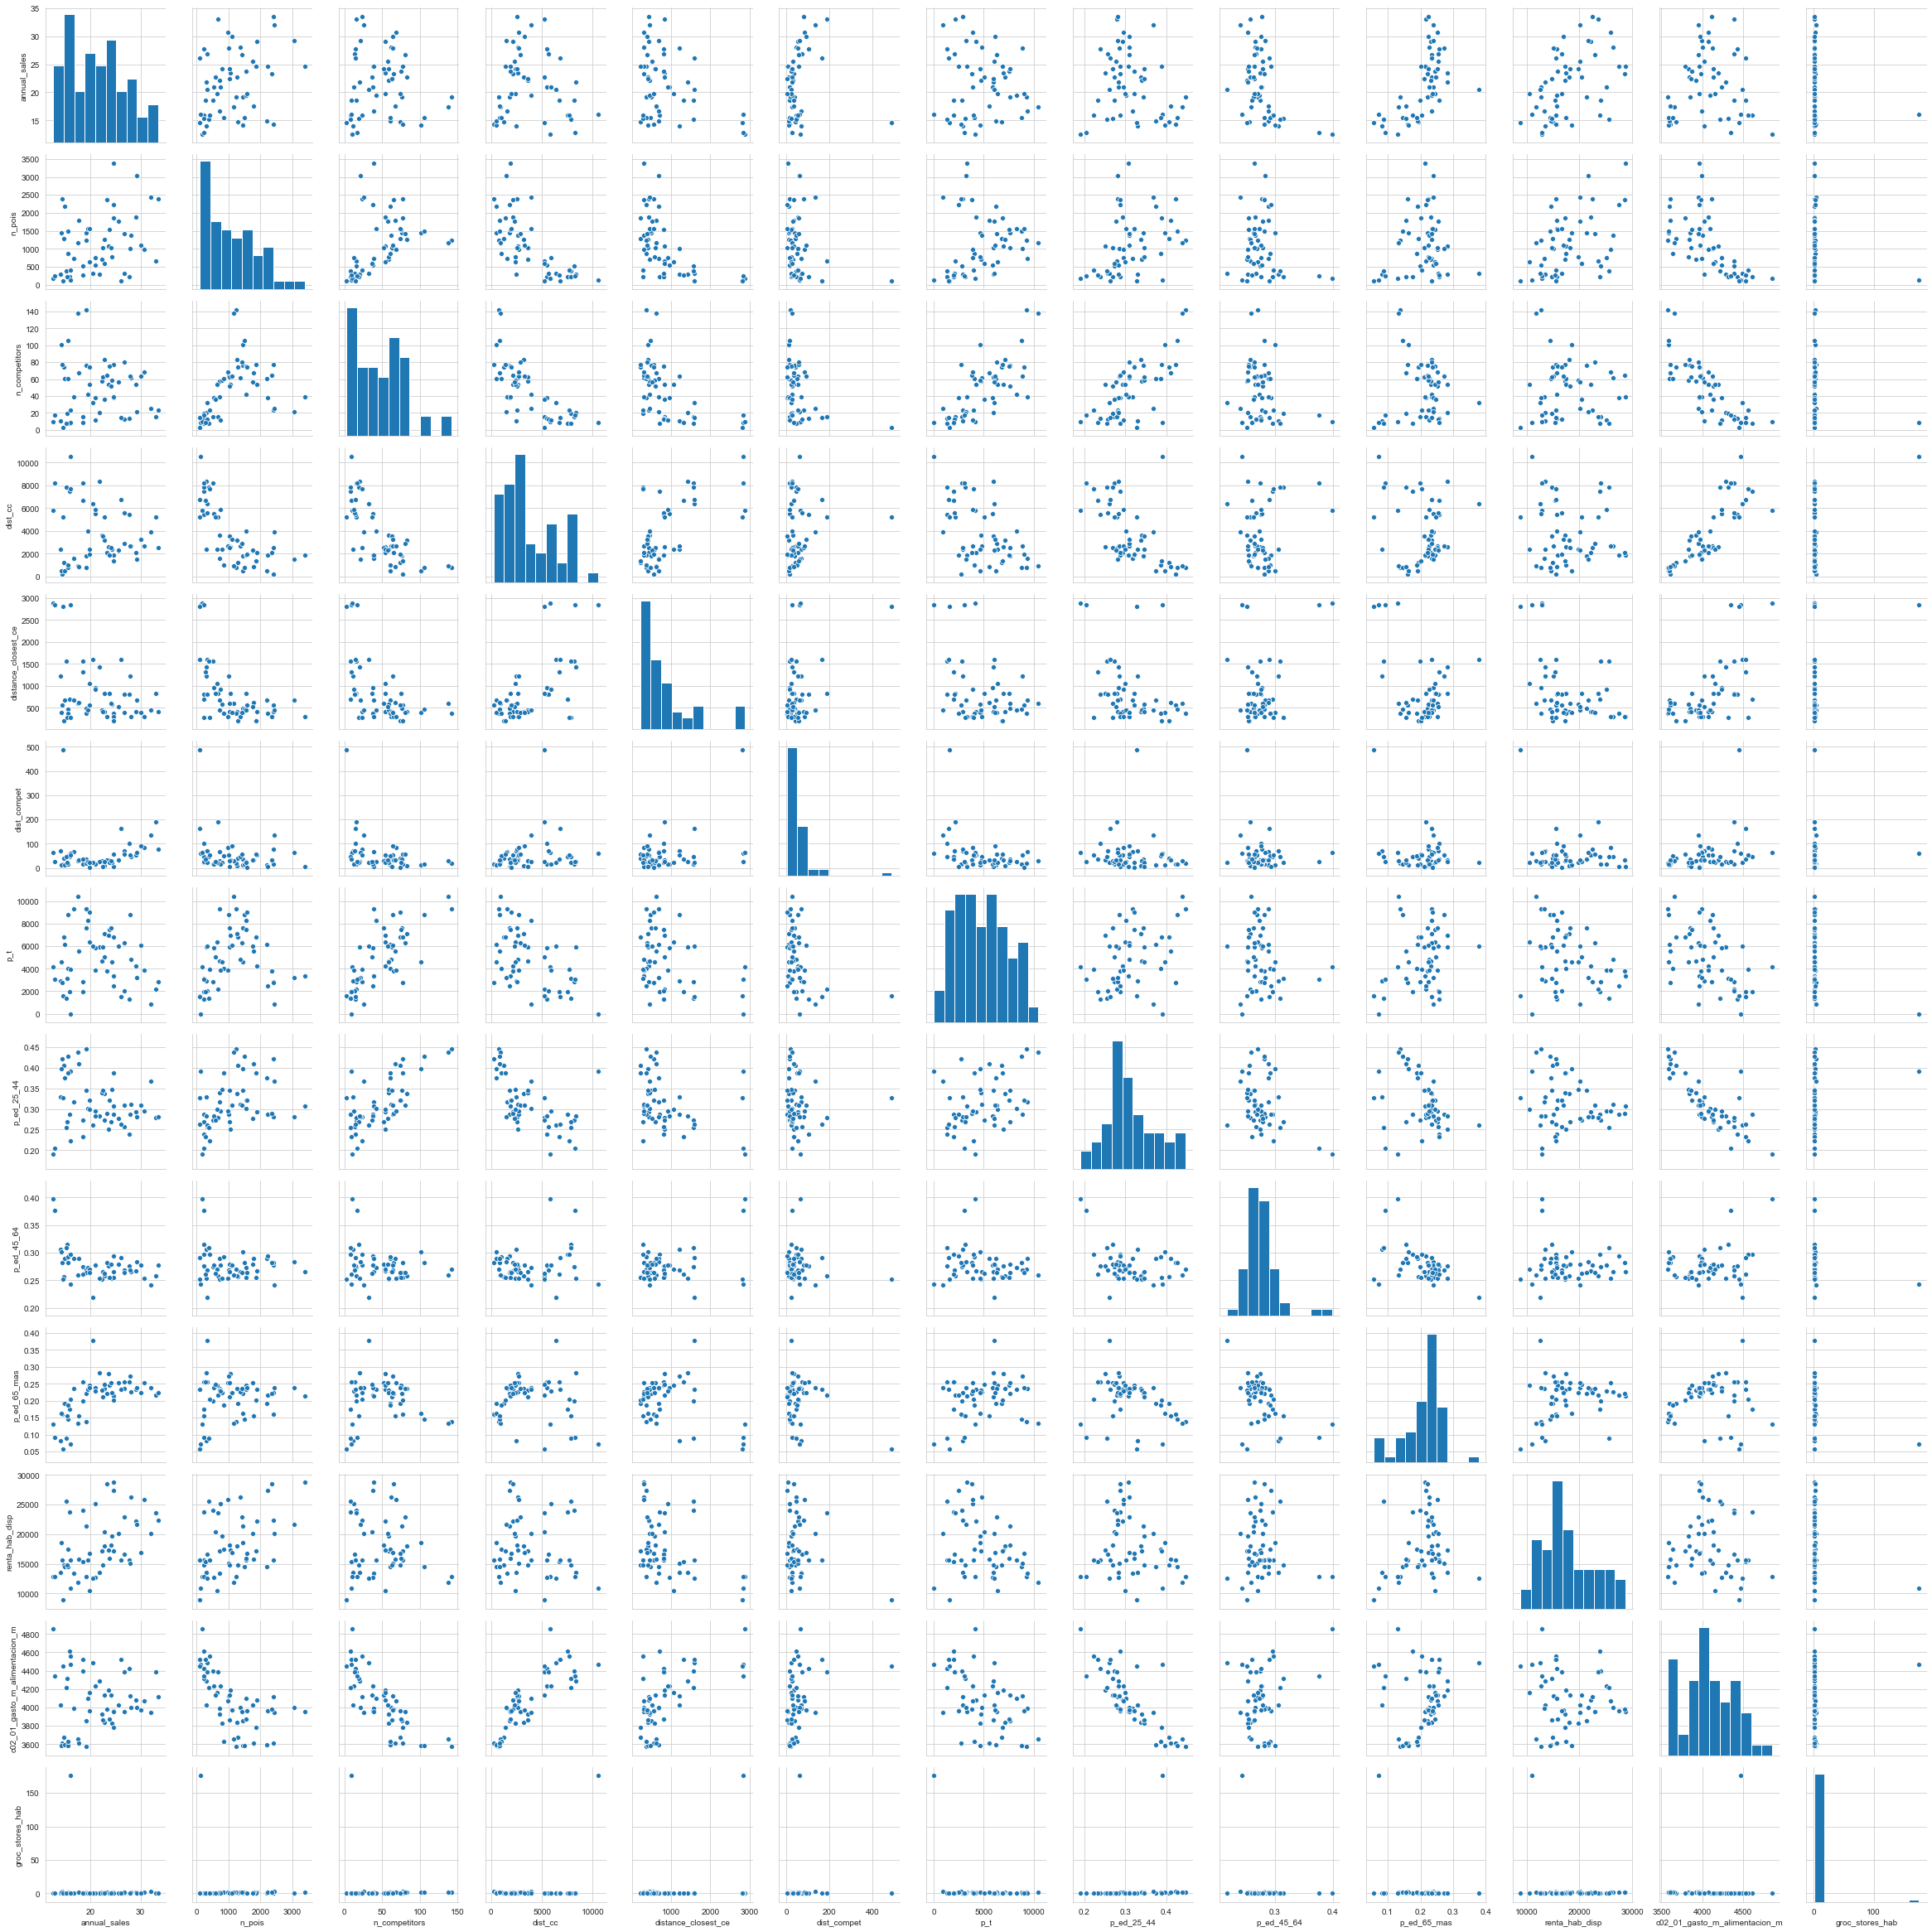

In [100]:
sns.pairplot(stores[plt_vars])
plt.tight_layout()

In [101]:
def plot_corr_matrix(df, item_list, plot_name):
    sns.set(style="white")
    # Compute the correlation matrix
    corr = df[item_list].corr()
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = matplotlib.cm.get_cmap('coolwarm')
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.1, cbar_kws={"shrink": .4})
    plt.title(plot_name, fontsize=15, color='black', weight='medium')
    sns.set()

In [102]:
item_list = ['annual_sales', 'n_pois',
       'n_competitors', 'dist_cc', 'distance_closest_ce', 'dist_compet', 'p_t',
       'p_ed_00_14_m', 'p_ed_00_14_h', 'p_ed_15_24_m', 'p_ed_15_24_h',
       'p_ed_25_44_m', 'p_ed_25_44_h', 'p_ed_45_64_m', 'p_ed_45_64_h',
       'p_ed_65_79_m', 'p_ed_65_79_h', 'p_ed_80_mas_m', 'p_ed_80_mas_h',
       'renta_hab_disp', 'c02_01_gasto_m_alimentacion_m', 'groc_stores_hab',
       'p_ed_00_14', 'p_ed_15_24', 'p_ed_25_44', 'p_ed_45_64', 'p_ed_65_79',
       'p_ed_80_mas', 'p_ed_65_mas']

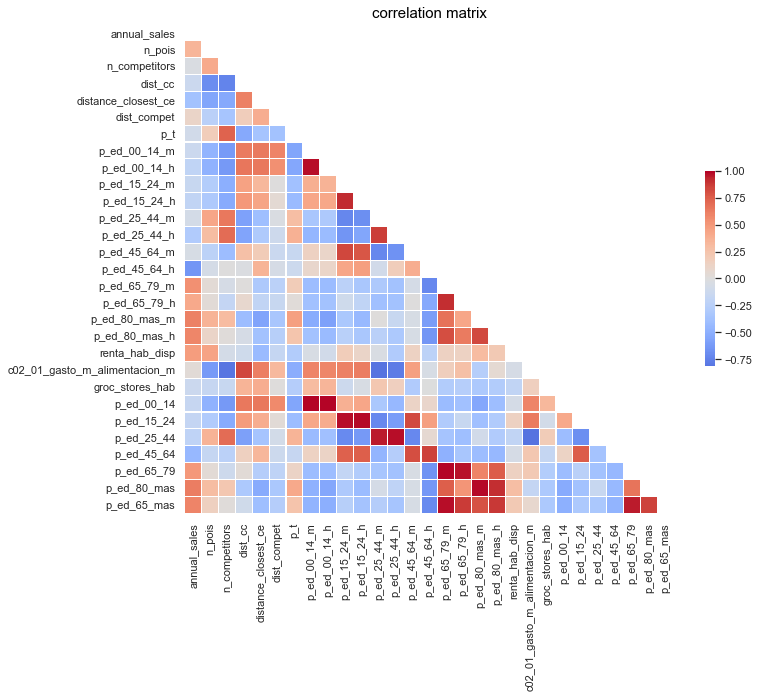

In [113]:
plot_corr_matrix(stores, item_list, 'correlation matrix')

### 4.3 Building the model

#### 4.3.1 Feature selection

We have identified some variables which are very strongly correlated. In addition, the number of variables is large (29) with respect to the number of obervations (55).

Feature selection is done applying Recursive Feature Elimination and Cross-Validated selection.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

In [151]:
# Escogemos random forest porque la relación de los features con la variable no tienen relación lineal. Además
# no le importa que tenga outliers.

# nestimadores 15 arboles. 
rf_reg = RandomForestRegressor(n_estimators=15, max_depth=3, min_samples_leaf=3, random_state=111)

## Corre el modelo comparando variables y elimina la más débil. Así iterando hasta quedarse con aquellas
## que añaden información.

selector = RFECV(rf_reg, step=1, cv=5)

In [152]:
predictors = ['n_pois', 'n_competitors', 'dist_cc', 'distance_closest_ce', 'dist_compet', 'p_t',
       'renta_hab_disp', 'c02_01_gasto_m_alimentacion_m', 'groc_stores_hab',
       'p_ed_00_14', 'p_ed_15_24', 'p_ed_25_44', 'p_ed_45_64', 'p_ed_65_79',
       'p_ed_80_mas', 'p_ed_65_mas']

In [153]:
len(predictors)

16

In [154]:
X = stores[predictors]
y = stores['annual_sales']

In [155]:
selector.fit(X, y)

RFECV(cv=5,
      estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mse', max_depth=3,
                                      max_features='auto', max_leaf_nodes=None,
                                      max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=3, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=15, n_jobs=None,
                                      oob_score=False, random_state=111,
                                      verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [156]:
## Son 9 las features con las que se queda de las 16 que le metimos inicialmente.
selector.n_features_

9

In [157]:
pd.Series(predictors)[selector.support_.tolist()]

0              n_pois
4         dist_compet
5                 p_t
6      renta_hab_disp
8     groc_stores_hab
11         p_ed_25_44
13         p_ed_65_79
14        p_ed_80_mas
15        p_ed_65_mas
dtype: object

In [158]:
predictors = pd.Series(predictors)[selector.support_.tolist()].tolist()

In [159]:
print(predictors, len(predictors))

['n_pois', 'dist_compet', 'p_t', 'renta_hab_disp', 'groc_stores_hab', 'p_ed_25_44', 'p_ed_65_79', 'p_ed_80_mas', 'p_ed_65_mas'] 9


#### 4.3.2 Model training

In [165]:
X = stores[predictors]
y = stores['annual_sales']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [167]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=None, oob_score=False,
                      random_state=111, verbose=0, warm_start=False)

In [168]:
rf_reg.feature_importances_

array([7.05993760e-03, 3.33753689e-01, 3.24417407e-03, 2.33290040e-02,
       7.62320332e-02, 2.88751753e-04, 1.33707826e-02, 1.19461676e-01,
       4.23259952e-01])

In [169]:
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))

0.8726861021871125
0.7867295217617248


In [170]:
print('METRIC SUMMARY')
print('MSE', mean_squared_error(y_test, rf_reg.predict(X_test)))
print('RMSE', np.sqrt(mean_squared_error(y_test, rf_reg.predict(X_test))))
print('MSLE', mean_squared_log_error(y_test, rf_reg.predict(X_test)))
print('MAE', mean_absolute_error(y_test, rf_reg.predict(X_test)))
print('R2', r2_score(y_test, rf_reg.predict(X_test)))

METRIC SUMMARY
MSE 6.930596164484783
RMSE 2.632602545863082
MSLE 0.017116628792583702
MAE 2.068462616660711
R2 0.7867295217617248


#### 4.3.3 Error analysis

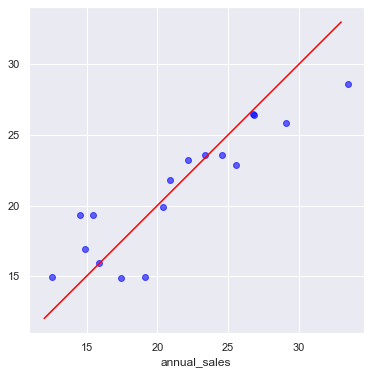

In [171]:
plt.figure(figsize=(6,6))
sns.regplot(y_test, rf_reg.predict(X_test), color='blue', scatter_kws={'alpha':0.6}, fit_reg=False)
sns.lineplot([12, 33], [12, 33], color='red')

In [172]:
stores['sales_pred'] = rf_reg.predict(stores[predictors])
stores['residual'] = stores['annual_sales'] - stores['sales_pred']

In [173]:
## PARA EXPLOTAR LOS DATOS GEOGRÁFICOS. Lo que está cerca se parece más a lo que está cerca que lo que está lejos.
## Eliminación de ruido y cálculo del error en versión espacial.
## Sirve para crear una capa en 3D de error de estimación y subestimación.
Map(Layer(stores, style=color_bins_style('residual', palette='tropic')))

#### 4.3.4 Algorithm optimization

_Out of scope_

#### 4.3.5 Model explainability

In [174]:
importances = pd.DataFrame(rf_reg.feature_importances_, index=predictors, columns=['importance']).sort_values('importance', ascending=False)
importances

,importance
p_ed_65_mas,0.423260
dist_compet,0.333754
p_ed_80_mas,0.119462
groc_stores_hab,0.076232
renta_hab_disp,0.023329
p_ed_65_79,0.013371
n_pois,0.007060
p_t,0.003244
p_ed_25_44,0.000289


Text(0.5, 1.0, 'Feature importance')

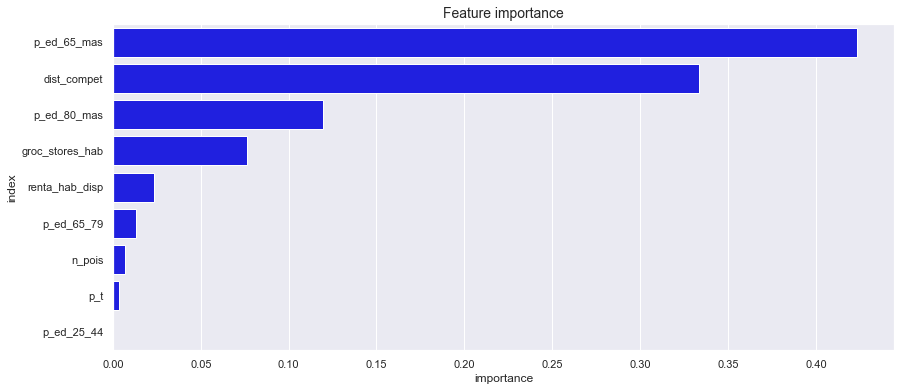

In [175]:
plt.figure(figsize=(14,6))
sns.barplot(x='importance', y='index', data=importances.reset_index()[:9], color='blue')
plt.title('Feature importance', size=14)

In [180]:
# Note: Shap package is imported at this point because otherwise it interferes with CF
import shap
shap.initjs()

In [177]:
explainer = shap.TreeExplainer(rf_reg)
shap_values = explainer.shap_values(stores[predictors])

Exception: Model type not yet supported by TreeExplainer: <class 'sklearn.ensemble._forest.RandomForestRegressor'>

In [179]:
shap.summary_plot(shap_values, stores[predictors])

NameError: name 'shap_values' is not defined

## 5. Next steps: Model projection

Once we have identified what is driving sales and we have built a predictive model, we are able to predict annual sales at different locations.

This model can be also used to identify areas in a city with a high sales potential. In order to identify these areas, the whole area of interest is discretized using some grid. Here, we present some of the ideas that could be used in order to perform this more advanced analysis.

We will use 

In [181]:
mad_geom = pd.read_csv('data/mad_muni_geom.csv')
mad_geom.rename(columns={'the_geom_wkt':'geometry'}, inplace=True)
mad_geom['geometry'] = mad_geom['geometry'].apply(wkt.loads)
mad_geom = gpd.GeoDataFrame(mad_geom, crs='epsg:4326')
mad_geom

,id,name,prov_id,prov_name,geometry
0,34132828079,Madrid,28,Madrid,"MULTIPOLYGON (((-3.88558 40.57446, -3.88381 40..."


In [182]:
zoom = 16

In [183]:
bounds = mad_geom.geometry.iloc[0].bounds
tiles = mercantile.tiles(bounds[0], bounds[1], bounds[2], bounds[3], zooms=zoom)

In [184]:
qks = []
geoms = []
for tile in tiles:
    qks.append(mercantile.quadkey(tile))
    geoms.append(box(*mercantile.bounds(tile)))
    
qk_grid = pd.DataFrame(data={'quadkey':qks, 'geom':geoms})
qk_grid = gpd.GeoDataFrame(qk_grid, geometry='geom', crs='epsg:4326')
qk_grid = qk_grid[qk_grid.geometry.intersects(mad_geom.geometry.iloc[0])]
qk_grid.head(2)

,quadkey,geom
14,0331110102133320,"POLYGON ((-3.88367 40.58476, -3.88367 40.58893..."
15,0331110102133322,"POLYGON ((-3.88367 40.58058, -3.88367 40.58476..."


In [185]:
Map(Layer(qk_grid, style=basic_style(opacity=0.3)))